# Transport Network Damage Simulation 

## 0 Setup environment

In [1]:
import os
import warnings
from glob import glob
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = "data"
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_weighted.graphml")
CENTRALITY_FILE = os.path.join(BASE_PATH, "centrality_measures.csv")
TRAVEL_TIMES_FILE = os.path.join(BASE_PATH, "travel_times.csv")
SWATHS_DIR = os.path.join(BASE_PATH, "storm_swath_geometries")

RESULTS_DIR = os.path.join(BASE_PATH, "simulation_results")
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
DAMAGE_LEVELS = [0.12, 0.25, 0.50, 1.00, 2.00, 3.00, 4.00, 5.00, 10.00, 20.00, 30.00, 40.00, 50.00]
REMOVAL_STRATEGIES = ["degree", "betweenness", "closeness", "random"]

## 1 Load simulation data

In [ ]:
graph_transport = ox.load_graphml(TRANSPORT_NETWORK_FILE)
for _, _, data in graph_transport.edges(data=True):
    data["segment_time"] = float(data["segment_time"])

In [ ]:
gdf_nodes = ox.graph_to_gdfs(graph_transport, edges=False)
gdf_swaths = pd.concat([gpd.read_file(f) for f in glob(os.path.join(SWATHS_DIR, "*.gpkg"))], ignore_index=True)
gdf_swaths = gdf_swaths.head(100)
nodes_in_swaths = gpd.sjoin(gdf_nodes, gdf_swaths, how="inner", predicate="within")

In [ ]:
df_centrality = pd.read_csv(CENTRALITY_FILE).set_index("osmid")
df_travel_times = pd.read_csv(TRAVEL_TIMES_FILE)
base_travel_times = df_travel_times["travel_time"].values
origin_nodes = df_travel_times["origin_node"].values
destination_nodes = df_travel_times["destination_node"].values

## 2 Define helper functions

In [ ]:
def rank_removable_nodes(ranked_nodes, damage_level):
    if not ranked_nodes:
        return []
    count = int((damage_level / 100) * len(ranked_nodes))
    return ranked_nodes[:count]


def compute_new_travel_times(graph, nodes_to_remove, origins, destinations):
    graph_damaged = graph.subgraph([n for n in graph.nodes if n not in nodes_to_remove])
    times = []
    for origin, destination in zip(origins, destinations):
        try:
            time = nx.dijkstra_path_length(graph_damaged, source=origin, target=destination, weight="segment_time")
        except nx.NetworkXNoPath:
            time = np.inf
        times.append(time)
    return times


def compute_efficiency(base_times, new_times):
    n = len(base_times)
    if n == 0:
        return 0.0
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = np.array(base_times) / np.array(new_times)
        ratio = np.nan_to_num(ratio, nan=0.0, neginf=0.0)
    log_term = np.log2(1 + ratio)
    return np.sum(log_term) / n


def run_storm_task(graph, base_times, origins, destinations, sid, ranked_nodes, strategy, level):
    nodes_to_remove = rank_removable_nodes(ranked_nodes, level)
    new_times = compute_new_travel_times(graph, nodes_to_remove, origins, destinations)
    efficiency = compute_efficiency(base_times, new_times)
    return {
        "storm_id": sid,
        "node_removal_strategy": strategy,
        "damage_level": level,
        "delivery_efficiency": efficiency,
    }


def get_removable_nodes(storm_id, nodes_in_swaths, origins, destinations):
    swath_nodes = nodes_in_swaths[nodes_in_swaths["SID"] == storm_id].index.tolist()
    protected_nodes = set(origins) | set(destinations)
    removable_nodes = [node for node in swath_nodes if node not in protected_nodes]
    return removable_nodes


def get_ranked_nodes(removable_nodes, df_centrality):
    ranked_nodes = {}

    if removable_nodes:
        centrality_nodes = df_centrality.loc[removable_nodes]
        for strategy in ["degree", "betweenness", "closeness"]:
            ranked_nodes[strategy] = centrality_nodes[strategy].sort_values(ascending=False).index.tolist()
        ranked_nodes["random"] = list(np.random.permutation(removable_nodes))
    else:
        for strategy in REMOVAL_STRATEGIES:
            ranked_nodes[strategy] = []

    return ranked_nodes

## 3 Run simulation

In [ ]:
for storm in gdf_swaths.itertuples():
    sid = storm.SID
    result_file = os.path.join(RESULTS_DIR, f"storm_{sid}.csv")
    if os.path.exists(result_file):
        print(f"✅ Storm {sid}: result file exists. Skipping.")
        continue

    removable_nodes = get_removable_nodes(sid, nodes_in_swaths, origin_nodes, destination_nodes)
    ranked_nodes = get_ranked_nodes(removable_nodes, df_centrality)

    results = []
    task_args = list(product(REMOVAL_STRATEGIES, DAMAGE_LEVELS))

    for strategy, level in tqdm(task_args, desc=f"Processing Storm {sid}"):
        result = run_storm_task(
            graph_transport,
            base_travel_times,
            origin_nodes,
            destination_nodes,
            sid,
            ranked_nodes[strategy],
            strategy,
            level,
        )
        results.append(result)

    df_result = pd.DataFrame(results)
    df_result.to_csv(result_file, index=False)

## 4 Analyze results

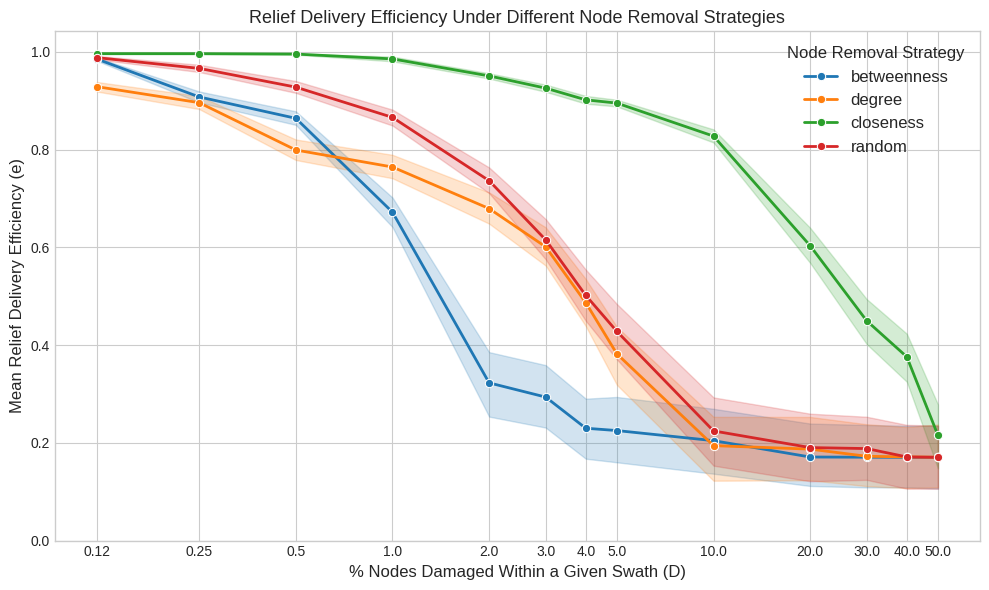

In [4]:
all_files = [os.path.join(RESULTS_DIR, f) for f in os.listdir(RESULTS_DIR) if f.endswith(".csv")]
df_results = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

plt.style.use("seaborn-v0_8-whitegrid")
_, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=df_results,
    x="damage_level",
    y="delivery_efficiency",
    hue="node_removal_strategy",
    ax=ax,
    linewidth=2,
    hue_order=["betweenness", "degree", "closeness", "random"],
    errorbar=("ci", 75),
    marker="o",
)

ax.set_title("Relief Delivery Efficiency Under Different Node Removal Strategies", fontsize=13)
ax.set_xlabel("% Nodes Damaged Within a Given Swath (D)", fontsize=12)
ax.set_ylabel("Mean Relief Delivery Efficiency (e)", fontsize=12)
ax.set_xscale("log")
ax.set_xticks(DAMAGE_LEVELS, labels=DAMAGE_LEVELS)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(title="Node Removal Strategy", title_fontsize="12", fontsize="12")

plt.savefig(os.path.join(BASE_PATH, "damage_simulation.png"), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()